# GD1. ResNet Ablation Study

## 1. 데이터셋 준비하기

- 데이터셋: `tensorflow-datasets`에서 제공하는 `cats_vs_dogs` 데이터셋 사용  


- 데이터 정보 확인: features, 개수 확인  


- input normalization: 각 채널별 최댓값인 255로 정규화  

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [61]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

dataset_name = 'cats_vs_dogs'
(ds_train, ds_test), ds_info = tfds.load('cats_vs_dogs', split=['train[:80%]', 'train[80%:]'], shuffle_files=True, with_info=True)
ds_train, ds_info_train = tfds.load('cats_vs_dogs',split='train[:80%]',as_supervised=True,  with_info=True)
ds_test, ds_info_test = tfds.load('cats_vs_dogs',split='train[80%:]',as_supervised=True,  with_info=True)

### 1-1. 데이터 정보 확인

In [51]:
print(ds_info_train.features)
print(ds_info_test.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})
FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [7]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [10]:
ds_info_train.features["label"].names

['cat', 'dog']

### 1-2. Input Normalization

In [15]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [16]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [17]:
ds_info_train.features["label"].num_classes

2

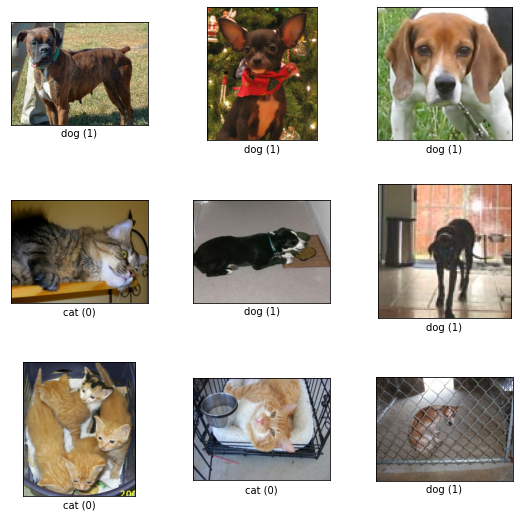

In [18]:
fig = tfds.show_examples(ds_train, ds_info_train)

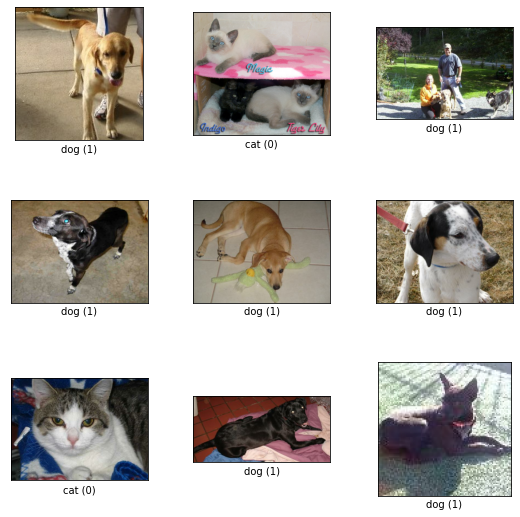

In [19]:
fig = tfds.show_examples(ds_test, ds_info_test)

---
## 2. ResNet-34, ResNet-50 Complete Model
- ResNet-18, 34, 50, 101, 152 다섯 가지 네트워크 중 34, 50 네트워크 구현

In [20]:
res_input_layer = keras.layers.Input(shape=(224,224,3))

### 2-1. ResNet-34

In [25]:
# resnet_34
def resnet_34(input_layer):
    x = input_layer
    
    # conv1
    x = keras.layers.Conv2D(64,(7,7), strides=(2,2), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.MaxPool2D(pool_size=(3,3),strides=2)(x)
    shortcut = x

    # conv2
    x = keras.layers.Conv2D(64,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(64,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)
    shortcut = x
    
    x = keras.layers.Conv2D(64,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(64,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)
    shortcut = x

    x = keras.layers.Conv2D(64,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(64,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)
        
    # conv3
    shortcut = keras.layers.Conv2D(128,(1,1), strides=(2,2), padding='valid')(x) # 패딩하지 않음
    shortcut = keras.layers.BatchNormalization()(shortcut)
    
    x = keras.layers.Conv2D(128,(3,3), strides=(2,2), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(128,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)
    shortcut = x

    x = keras.layers.Conv2D(128,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(128,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)
    shortcut = x

    x = keras.layers.Conv2D(128,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(128,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)
    shortcut = x

    x = keras.layers.Conv2D(128,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(128,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)

    # conv4
    shortcut = keras.layers.Conv2D(256,(1,1), strides=(2,2), padding='valid')(x) # 패딩하지 않음
    shortcut = keras.layers.BatchNormalization()(shortcut)
    
    x = keras.layers.Conv2D(256,(3,3), strides=(2,2), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)
    shortcut = x
    
    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)
    shortcut = x
    

    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)
    shortcut = x
    

    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)
    shortcut = x

    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)
    shortcut = x
    
    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)
    
    # conv5
    shortcut = keras.layers.Conv2D(512,(1,1), strides=(2,2), padding='valid')(x) # 패딩하지 않음
    shortcut = keras.layers.BatchNormalization()(shortcut)
    
    x = keras.layers.Conv2D(512,(3,3), strides=(2,2), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)
    shortcut = x

    x = keras.layers.Conv2D(512,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)
    shortcut = x

    x = keras.layers.Conv2D(512,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)

    # avg pool
    x = keras.layers.GlobalAvgPool2D()(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(2,activation='softmax')(x)

    model = keras.Model(inputs = input_layer, outputs = x)
    return model

In [26]:
resnet_34(res_input_layer).summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_49 (BatchNo (None, 112, 112, 64) 256         conv2d_49[0][0]                  
__________________________________________________________________________________________________
activation_49 (Activation)      (None, 112, 112, 64) 0           batch_normalization_49[0][0]     
____________________________________________________________________________________________

### 2-2. ResNet-50

In [27]:
# resnet_50
def resnet_50(input_layer):
    x = input_layer
    
    # conv1
    x = keras.layers.ZeroPadding2D((3,3))(x)
    x = keras.layers.Conv2D(64,(7,7), strides=(2,2), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.ZeroPadding2D((1,1))(x)
    x = keras.layers.MaxPool2D(pool_size=(3,3),strides=2)(x)
    
    
    shortcut = keras.layers.Conv2D(256,(1,1), padding='valid')(x) # 패딩하지 않음
    shortcut = keras.layers.BatchNormalization()(shortcut)
#     print(shortcut)
#     print(x)
    
    
    # conv2
    x = keras.layers.Conv2D(64,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(64,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)
    shortcut = x

    x = keras.layers.Conv2D(64,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(64,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)
    shortcut = x

    x = keras.layers.Conv2D(64,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(64,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)
    shortcut = x

        
    # conv3
    shortcut = keras.layers.Conv2D(512,(1,1), strides=(2,2), padding='valid')(shortcut) # 패딩하지 않음
    shortcut = keras.layers.BatchNormalization()(shortcut)
    
    x = keras.layers.Conv2D(128,(1,1), strides=(2,2), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(128,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)
    shortcut = x

    x = keras.layers.Conv2D(128,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(128,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)
    shortcut = x


    x = keras.layers.Conv2D(128,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(128,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)
    shortcut = x


    x = keras.layers.Conv2D(128,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(128,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)


    # conv4
    shortcut = keras.layers.Conv2D(1024,(1,1), strides=(2,2), padding='valid')(x) # 패딩하지 않음
    shortcut = keras.layers.BatchNormalization()(shortcut)
    
    x = keras.layers.Conv2D(256,(1,1), strides=(2,2), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(1024,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)
    shortcut = x
    
    x = keras.layers.Conv2D(256,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(1024,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)
    shortcut = x
    

    x = keras.layers.Conv2D(256,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(1024,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)
    shortcut = x
    

    x = keras.layers.Conv2D(256,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(1024,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)
    shortcut = x

    x = keras.layers.Conv2D(256,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(1024,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)
    shortcut = x
    
    x = keras.layers.Conv2D(256,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(1024,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)


    
    # conv5
    shortcut = keras.layers.Conv2D(2048,(1,1), strides=(2,2), padding='valid')(x) # 패딩하지 않음
    shortcut = keras.layers.BatchNormalization()(shortcut)
    
    x = keras.layers.Conv2D(512,(1,1), strides=(2,2), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(2048,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)
    shortcut = x

    x = keras.layers.Conv2D(512,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(2048,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)
    shortcut = x


    x = keras.layers.Conv2D(512,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(2048,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    x = keras.layers.Activation('relu')(x)

    # avg pool
    x = keras.layers.GlobalAvgPool2D()(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(2,activation='softmax')(x)

    model = keras.Model(inputs = input_layer, outputs = x)
    return model

In [28]:
resnet_50(res_input_layer).summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_85 (Conv2D)              (None, 115, 115, 64) 9472        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
batch_normalization_85 (BatchNo (None, 115, 115, 64) 256         conv2d_85[0][0]                  
____________________________________________________________________________________________

---
## 3. 일반 네트워크(plain network) 만들기
- 블록 코드 수정하기 (skip connection 제거)

### 3-1. plain 34

In [29]:
# plain 34
def plain_34(input_layer):
    
    x = input_layer
    
    # conv1
    x = keras.layers.Conv2D(64,(7,7), strides=(2,2), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.MaxPool2D(pool_size=(3,3),strides=2)(x)

    # conv2
    x = keras.layers.Conv2D(64,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(64,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(64,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(64,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(64,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(64,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    # conv3
    x = keras.layers.Conv2D(128,(3,3), strides=(2,2), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(128,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(128,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(128,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(128,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(128,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(128,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    
    x = keras.layers.Conv2D(128,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    
    # conv4

    x = keras.layers.Conv2D(256,(3,3), strides=(2,2), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    # conv5

    x = keras.layers.Conv2D(512,(3,3), strides=(2,2), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(512,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(512,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(512,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(512,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(512,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    # avg pool
    x = keras.layers.GlobalAvgPool2D()(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(2,activation='softmax')(x)


    model = keras.Model(inputs = input_layer, outputs = x)
    return model


In [30]:
plain_34(res_input_layer).summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_138 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_138 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
activation_131 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_139 (Conv2D)          (None, 55, 55, 64)        36928     
_________________________________________________________________
batch_normalization_139 (Bat (None, 55, 55, 64)        256 

### 3-2. plain 50

In [31]:
# plain_50
def plain_50(input_layer):
    x = input_layer
    
    # conv1
    x = keras.layers.ZeroPadding2D((3,3))(x)
    x = keras.layers.Conv2D(64,(7,7), strides=(2,2), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.ZeroPadding2D((1,1))(x)
    x = keras.layers.MaxPool2D(pool_size=(3,3),strides=2)(x)
    
    # conv2
    x = keras.layers.Conv2D(64,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(64,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(64,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(64,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)


    x = keras.layers.Conv2D(64,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(64,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

        
    # conv3
    x = keras.layers.Conv2D(128,(1,1), strides=(2,2), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(128,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(128,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(128,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(128,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(128,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(128,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(128,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    # conv4
    x = keras.layers.Conv2D(256,(1,1), strides=(2,2), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(1024,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    
    x = keras.layers.Conv2D(256,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(1024,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    

    x = keras.layers.Conv2D(256,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(1024,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    

    x = keras.layers.Conv2D(256,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(1024,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)


    x = keras.layers.Conv2D(256,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(1024,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    
    x = keras.layers.Conv2D(256,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(1024,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)


    # conv5
    x = keras.layers.Conv2D(512,(1,1), strides=(2,2), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(2048,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(512,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(2048,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)


    x = keras.layers.Conv2D(512,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(2048,(1,1), padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    # avg pool
    x = keras.layers.GlobalAvgPool2D()(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(2,activation='softmax')(x)

    model = keras.Model(inputs = input_layer, outputs = x)
    return model

In [32]:
plain_50(res_input_layer).summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
zero_padding2d_4 (ZeroPaddin (None, 230, 230, 3)       0         
_________________________________________________________________
conv2d_171 (Conv2D)          (None, 115, 115, 64)      9472      
_________________________________________________________________
batch_normalization_171 (Bat (None, 115, 115, 64)      256       
_________________________________________________________________
activation_164 (Activation)  (None, 115, 115, 64)      0         
_________________________________________________________________
zero_padding2d_5 (ZeroPaddin (None, 117, 117, 64)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 58, 58, 64)        0   

---
## 4. 학습하기

In [62]:
BATCH_SIZE = 16
EPOCH = 20

In [63]:
input_layer = keras.layers.Input(shape=(224,224,3))

model_res_34 = resnet_34(input_layer)
model_res_50 = resnet_50(input_layer)
model_plain_34 = plain_34(input_layer)
model_plain_50 = plain_50(input_layer)

In [64]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)

In [65]:
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [163]:
model_res_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_34 = model_res_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
1163/1163 [==============================] - 338s 266ms/step - loss: 0.7183 - accuracy: 0.5929 - val_loss: 1.7381 - val_accuracy: 0.5209
Epoch 2/20
1163/1163 [==============================] - 332s 286ms/step - loss: 0.6112 - accuracy: 0.6678 - val_loss: 0.9815 - val_accuracy: 0.5613
Epoch 3/20
1163/1163 [==============================] - 309s 265ms/step - loss: 0.5610 - accuracy: 0.7187 - val_loss: 0.7899 - val_accuracy: 0.6420
Epoch 4/20
1163/1163 [==============================] - 309s 265ms/step - loss: 0.4943 - accuracy: 0.7606 - val_loss: 0.9503 - val_accuracy: 0.5744
Epoch 5/20
1163/1163 [==============================] - 309s 265ms/step - loss: 0.4112 - accuracy: 0.8101 - val_loss: 0.5154 - val_accuracy: 0.7754
Epoch 6/20
1163/1163 [==============================] - 309s 265ms/step - loss: 0.3481 - accuracy: 0.8511 - val_loss: 1.1424 - val_accuracy: 0.6598
Epoch 7/20
1163/1163 [==============================] - 309s 265ms/step - loss: 0.2612 - accuracy: 0.8903 - val_

In [69]:
h_resnet_34 = [
[0.7183, 0.5929, 1.7381, 0.5209],
[0.6112, 0.6678, 0.9815, 0.5613],
[0.5610, 0.7187, 0.7899, 0.6420],
[0.4943, 0.7606, 0.9503, 0.5744],
[0.4112, 0.8101, 0.5154, 0.7754],
[0.3481, 0.8511, 1.1424, 0.6598],
[0.2612, 0.8903, 0.5718, 0.7927],
[0.1625, 0.9357, 0.5929, 0.8324],
[0.1150, 0.9562, 0.7951, 0.8190],
[0.0672, 0.9750, 1.0594, 0.7791],
[0.0473, 0.9812, 0.6981, 0.8366],
[0.0407, 0.9870, 0.7416, 0.8456],
[0.0205, 0.9929, 0.7807, 0.8462],
[0.0113, 0.9956, 0.8059, 0.8391],
[0.0094, 0.9967, 0.8080, 0.8537],
[0.0072, 0.9972, 0.8489, 0.8606],
[0.0042, 0.9987, 0.8416, 0.8572],
[0.0020, 0.9993, 0.9689, 0.8499],
[0.0025, 0.9994, 0.8263, 0.8654],
[8.9776e-04, 0.9998, 0.8770, 0.8642]
]

history_resnet_34 = {'loss': [], 'accuracy': [],'val_loss': [], 'val_accuracy': []}                    
for i in range(20):
    history_resnet_34['loss'].append(h_resnet_34[i][0])
    history_resnet_34['accuracy'].append(h_resnet_34[i][1])    
    history_resnet_34['val_loss'].append(h_resnet_34[i][2])    
    history_resnet_34['val_accuracy'].append(h_resnet_34[i][3])    

history_resnet_34['loss']

[0.7183,
 0.6112,
 0.561,
 0.4943,
 0.4112,
 0.3481,
 0.2612,
 0.1625,
 0.115,
 0.0672,
 0.0473,
 0.0407,
 0.0205,
 0.0113,
 0.0094,
 0.0072,
 0.0042,
 0.002,
 0.0025,
 0.00089776]

In [165]:
model_res_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_50 = model_res_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
1163/1163 [==============================] - 586s 492ms/step - loss: 0.6794 - accuracy: 0.6021 - val_loss: 0.8557 - val_accuracy: 0.5477
Epoch 2/20
1163/1163 [==============================] - 565s 486ms/step - loss: 0.6771 - accuracy: 0.6077 - val_loss: 0.7557 - val_accuracy: 0.5705
Epoch 3/20
1163/1163 [==============================] - 567s 488ms/step - loss: 0.6599 - accuracy: 0.6270 - val_loss: 0.8560 - val_accuracy: 0.5699
Epoch 4/20
1163/1163 [==============================] - 567s 488ms/step - loss: 0.6411 - accuracy: 0.6455 - val_loss: 1.0810 - val_accuracy: 0.5192
Epoch 5/20
1163/1163 [==============================] - 566s 487ms/step - loss: 0.6403 - accuracy: 0.6513 - val_loss: 0.6628 - val_accuracy: 0.6225
Epoch 6/20
1163/1163 [==============================] - 567s 488ms/step - loss: 0.6229 - accuracy: 0.6623 - val_loss: 1.1846 - val_accuracy: 0.5631
Epoch 7/20
1163/1163 [==============================] - 568s 488ms/step - loss: 0.6005 - accuracy: 0.6827 - val_

In [71]:
h_resnet_50 = [
[0.6794, 0.6021, 0.8557, 0.5477],
[0.6771, 0.6077, 0.7557, 0.5705],
[0.6599, 0.6270, 0.8560, 0.5699],
[0.6411, 0.6455, 1.0810, 0.5192],
[0.6403, 0.6513, 0.6628, 0.6225],
[0.6229, 0.6623, 1.1846, 0.5631],
[0.6005, 0.6827, 0.5926, 0.6933],
[0.5873, 0.6934, 0.7289, 0.6050],
[0.5813, 0.6928, 0.5821, 0.6935],
[0.5561, 0.7193, 0.6466, 0.7047],
[0.5192, 0.7460, 0.5258, 0.7496],
[0.4910, 0.7651, 0.7099, 0.6578],
[0.4549, 0.7877, 0.5642, 0.7444],
[0.4131, 0.8149, 0.7383, 0.6953],
[0.3699, 0.8345, 0.9301, 0.6534],
[0.3137, 0.8647, 0.6103, 0.7593],
[0.2564, 0.8927, 0.8876, 0.7243],
[0.2036, 0.9182, 0.9631, 0.7274],
[0.1601, 0.9384, 0.9631, 0.7573],
[0.1165, 0.9525, 0.7355, 0.7996]
]

history_resnet_50 = {'loss': [], 'accuracy': [],'val_loss': [], 'val_accuracy': []}                    
for i in range(20):
    history_resnet_50['loss'].append(h_resnet_50[i][0])
    history_resnet_50['accuracy'].append(h_resnet_50[i][1])    
    history_resnet_50['val_loss'].append(h_resnet_50[i][2])    
    history_resnet_50['val_accuracy'].append(h_resnet_50[i][3])  

In [166]:
model_plain_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_34 = model_plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
1163/1163 [==============================] - 304s 253ms/step - loss: 0.7077 - accuracy: 0.5327 - val_loss: 1.0329 - val_accuracy: 0.5351
Epoch 2/20
1163/1163 [==============================] - 293s 252ms/step - loss: 0.6973 - accuracy: 0.5284 - val_loss: 1.1648 - val_accuracy: 0.5164
Epoch 3/20
1163/1163 [==============================] - 293s 252ms/step - loss: 0.6598 - accuracy: 0.6054 - val_loss: 0.7900 - val_accuracy: 0.5384
Epoch 5/20
1163/1163 [==============================] - 294s 252ms/step - loss: 0.6509 - accuracy: 0.6206 - val_loss: 0.6507 - val_accuracy: 0.6303
Epoch 6/20
1163/1163 [==============================] - 294s 252ms/step - loss: 0.6315 - accuracy: 0.6392 - val_loss: 0.6963 - val_accuracy: 0.6111
Epoch 7/20
1163/1163 [==============================] - 294s 253ms/step - loss: 0.6139 - accuracy: 0.6590 - val_loss: 0.7864 - val_accuracy: 0.6110
Epoch 8/20
1163/1163 [==============================] - 294s 253ms/step - loss: 0.5877 - accuracy: 0.6839 - val_

In [74]:
h_plain_34 = [
    [0.7077, 0.5327, 1.0329, 0.5351],
    [0.6973, 0.5284, 1.1648, 0.5164],
    [0.6598, 0.6054, 0.7900, 0.5384],
    [0.6509, 0.6206, 0.6507, 0.6303],
    [0.6400, 0.6300, 0.6700, 0.6200],
    [0.6315, 0.6392, 0.6963, 0.6111],
    [0.6139, 0.6590, 0.7864, 0.6110],
    [0.5877, 0.6839, 0.6003, 0.6976],
    [0.5535, 0.7150, 0.5412, 0.7317],
    [0.5097, 0.7427, 0.4551, 0.7899],
    [0.4633, 0.7764, 0.5005, 0.7588],
    [0.4136, 0.8151, 0.4044, 0.8149],
    [0.3581, 0.8442, 0.4357, 0.8097],
    [0.3126, 0.8661, 0.4068, 0.8138],
    [0.2725, 0.8884, 0.4083, 0.8252],
    [0.2314, 0.9056, 0.4621, 0.8199],
    [0.1900, 0.9205, 0.4434, 0.8147],
    [0.1501, 0.9411, 0.3356, 0.8760],
    [0.1218, 0.9548, 0.6391, 0.8341],
    [0.0923, 0.9671, 0.4248, 0.8714]
]

history_plain_34 = {'loss': [], 'accuracy': [],'val_loss': [], 'val_accuracy': []}                    
for i in range(20):
    history_plain_34['loss'].append(h_plain_34[i][0])
    history_plain_34['accuracy'].append(h_plain_34[i][1])    
    history_plain_34['val_loss'].append(h_plain_34[i][2])    
    history_plain_34['val_accuracy'].append(h_plain_34[i][3])  

In [66]:
model_plain_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_50 = model_plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
1163/1163 [==============================] - 547s 459ms/step - loss: 0.7109 - accuracy: 0.5240 - val_loss: 4.4119 - val_accuracy: 0.5196
Epoch 2/20
1163/1163 [==============================] - 492s 423ms/step - loss: 0.7072 - accuracy: 0.5273 - val_loss: 0.7181 - val_accuracy: 0.5429
Epoch 3/20
1163/1163 [==============================] - 492s 423ms/step - loss: 0.7047 - accuracy: 0.5279 - val_loss: 6.3546 - val_accuracy: 0.5183
Epoch 4/20
1163/1163 [==============================] - 491s 423ms/step - loss: 0.7056 - accuracy: 0.5163 - val_loss: 0.7552 - val_accuracy: 0.5394
Epoch 5/20
1163/1163 [==============================] - 488s 419ms/step - loss: 0.7047 - accuracy: 0.5089 - val_loss: 3.7094 - val_accuracy: 0.5114
Epoch 6/20
1163/1163 [==============================] - 488s 420ms/step - loss: 0.7057 - accuracy: 0.5251 - val_loss: 0.9937 - val_accuracy: 0.5457
Epoch 7/20
1163/1163 [==============================] - 491s 422ms/step - loss: 0.6989 - accuracy: 0.5402 - val_

---
## 5. 시각화 및 결과 비교

### 5-1. test 결과 
- **resnet 34, plain 34 (val accuracy, val loss)** 
    - resnet34가 plain 34에 비해 accuracy가 더 높게 나타나는 것을 볼 수 있다. 하지만 loss 값을 보면 이 역시도 resnet34가 더 높게 나타났다.  
    - 해당 결과만 보았을 때는 학습이 뒤로 갈수록 두 모델의 정확도가 모두 비슷한 수준으로 올라가지만, loss 값을 보면 resnet34이 더 높은 수준으로 나타나기 때문에  resnet34가 더 좋다고 명확하게 말하기는 어려울 것 같다.  



- **resnet 50, plain 50 (val accuracy, val loss)**
    - resnet 50과 plain 50을 비교해보았을 때, accuracy가 resnet50이 더 안정적이면서 높게 증가하는 것을 볼 수 있다.
    - loss 값을 비교했을 때도 resnet50이 상대적으로 안정적으로 낮은 loss를 보인다.

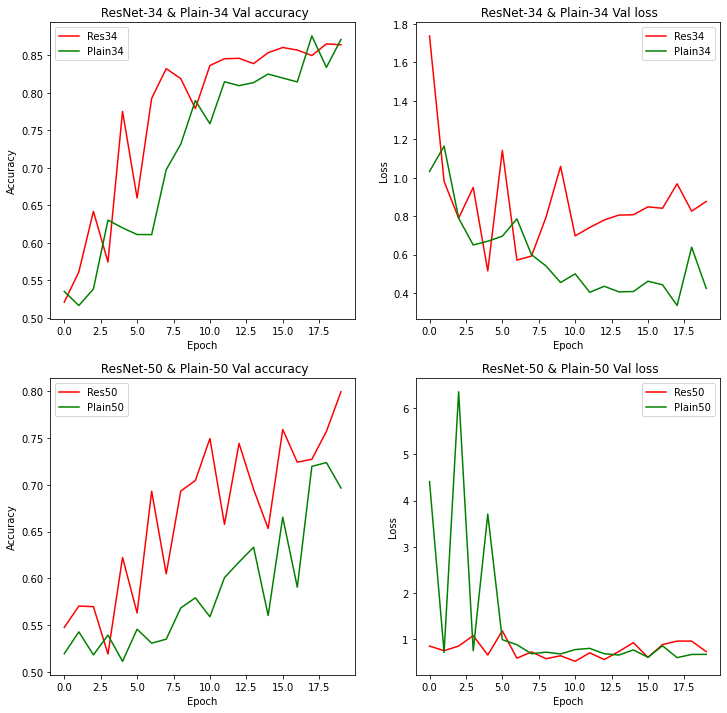

In [91]:
plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.plot(history_resnet_34['val_accuracy'], 'r')
plt.plot(history_plain_34['val_accuracy'], 'g')
plt.title(' ResNet-34 & Plain-34 Val accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Res34', 'Plain34'])

plt.subplot(2, 2, 2)
plt.plot(history_resnet_34['val_loss'], 'r')
plt.plot(history_plain_34['val_loss'], 'g')
plt.title(' ResNet-34 & Plain-34 Val loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Res34', 'Plain34'])

plt.subplot(2, 2, 3)
plt.plot(history_resnet_50['val_accuracy'], 'r')
plt.plot(history_plain_50.history['val_accuracy'], 'g')
plt.title(' ResNet-50 & Plain-50 Val accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Res50', 'Plain50'])

plt.subplot(2, 2, 4)
plt.plot(history_resnet_50['val_loss'], 'r')
plt.plot(history_plain_50.history['val_loss'], 'g')
plt.title(' ResNet-50 & Plain-50 Val loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Res50', 'Plain50'])

plt.show()

### 5-2. Train Loss
- **resnet 34, plain 34 (train loss)**
    - train loss 값은 resnet34가 더 빠른 시점에 큰 감소폭으로 줄어드는 것을 확인 할 수 있으며, 낮은 수준의 loss값을 보였다.  

- **resnet 50, plain 50 (train loss)**
    - resnet50의 train loss 값이 상대적으로 더 빠르고 안정적으로 감소하는 것을 볼 수 있다.

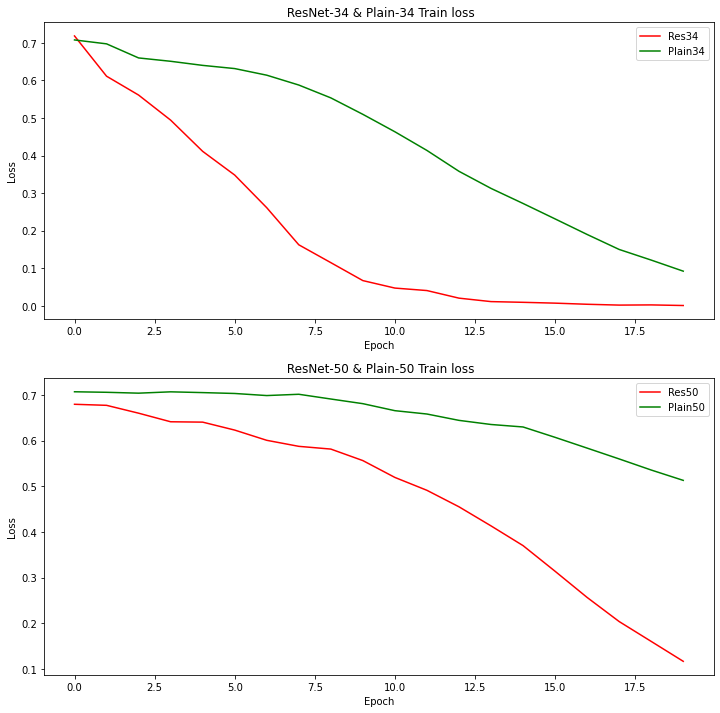

In [85]:
plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
plt.plot(history_resnet_34['loss'], 'r')
plt.plot(history_plain_34['loss'], 'g')
plt.title(' ResNet-34 & Plain-34 Train loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Res34', 'Plain34'])

plt.subplot(2, 1, 2)
plt.plot(history_resnet_50['loss'], 'r')
plt.plot(history_plain_50.history['loss'], 'g')
plt.title(' ResNet-50 & Plain-50 Train loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Res50', 'Plain50'])

plt.show()

### 5-3. Train Loss (2)
- **resnet 34, resnet 50 (train loss)**
    - 20epoch로 학습하였을 때 resnet34의 loss가 resnet50에 비해 여전히 적다. 
    - 하지만 적지 않은 감소폭으로 점진적으로 감소하고 있기 때문에 epoch를 늘리면 더 낮은 loss를 보일수도 있지 않을까 조심스럽게 생각해본다.    



- **plain 34, plain 50 (train loss)**
    - plain50이 plain34에 비해 감소폭이 적다.  
    - epoch를 늘려보면 좀 더 명확한 결과를 확인할 수 있을 것 같다.


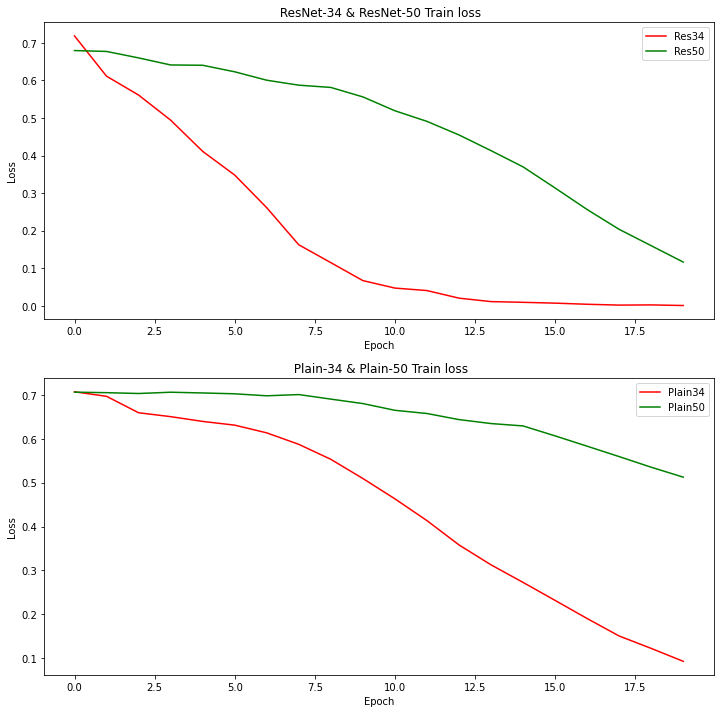

In [84]:
plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
plt.plot(history_resnet_34['loss'], 'r')
plt.plot(history_resnet_50['loss'], 'g')
plt.title(' ResNet-34 & ResNet-50 Train loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Res34', 'Res50'])

plt.subplot(2, 1, 2)
plt.plot(history_plain_34['loss'], 'r')
plt.plot(history_plain_50.history['loss'], 'g')
plt.title(' Plain-34 & Plain-50 Train loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Plain34', 'Plain50'])

plt.show()

### 5-4. Train Accuracy
- **resnet 34, resnet 50 (train accuracy)**
    - 그래프를 보면 resnet34가 매우 높은 accuracy를 보이지만, resnet50의 증가폭을 고려한다면 epoch를 늘렸을 때 resnet50도 더 높은 accuracy 가지지 않을까 생각된다.  
    
    

- **plain 34, plain 50 (train accuracy)**
    - resnet 34의 accuracy가 더 높게 나타나는 것을 볼 수 있다. 

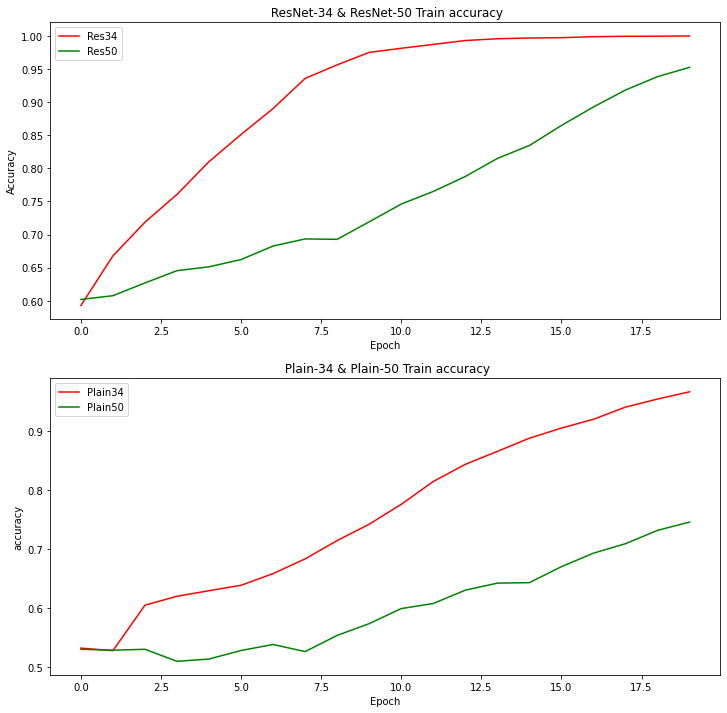

In [86]:
plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
plt.plot(history_resnet_34['accuracy'], 'r')
plt.plot(history_resnet_50['accuracy'], 'g')
plt.title(' ResNet-34 & ResNet-50 Train accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Res34', 'Res50'])

plt.subplot(2, 1, 2)
plt.plot(history_plain_34['accuracy'], 'r')
plt.plot(history_plain_50.history['accuracy'], 'g')
plt.title(' Plain-34 & Plain-50 Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Plain34', 'Plain50'])

plt.show()

---

## 6. 평가 및 회고

### 루브릭
|평가문항|상세기준|
|:--|:--|
|1. ResNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가|블록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다.|
|2. 구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가?|cats_vs_dogs 데이터셋으로 학습시 몇 epoch동안 안정적으로 loss 감소가 진행 확인되었다.|
|3. Ablation Study 결과가 바른 포맷으로 제출되었는가?|ResNet-34, ResNet-50 각각 plain모델과 residual모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표가 작성되었다.|

### 회고

 회고에 들어가기 전에 해당 프로젝트에 충분한 시간을 투자하지 못한 점을 반성합니다.  

 논문 내용을 파악하고 리뷰 영상 및 글을 찾아보는 등의 공부는 하였으나, 실질적으로 구현하기 위한 시간은 충분하지 못하였다고 생각합니다.  

<br>

 블록화를 진행하라고 하였으나 우선적으로 비블록화를 먼저 진행해보고 싶었습니다. 비블록화 구조를 파악한 후 블록화를 진행해보려고 하였으며, 블록화하여 구현한 Resnet은 가독성을 생각하여 추후에 별도 파일로 올려보려고 합니다.   

 프로젝트를 진행하면서 조금 당혹스러웠던 것은 블록화 코드는 참고할 자료가 많았지만, 비블록화 코드는 상대적으로 적었던 점이었습니다.  
 
 그렇기 때문에 프로젝트를 진행할 때 참고한 자료나, 대략적인 순서를 정리해보겠습니다.  
 
<br>
    
    
 프로젝트 진행에 앞서 상민 퍼실님이 추천해주신 논문 리뷰 영상을 먼저 보고 Resnet 논문을 먼저 읽고 전체적인 Resnet 구현 시 중점을 둬야 할 포인트를 고민해봤습니다.    
 논문을 읽을 때는 국진 퍼실님의 '논문 효율적으로 읽는법'을 참고하였습니다.  
 

<br>
    
  코드 작성 초기에는 상민 퍼실님이 전체적으로 해주신 설명이 큰 도움이 되었습니다. 덕분에 프로젝트 진행 전 큰 구성을 빠르게 잡을 수 있었던 것 같습니다.  
  
  비블록화 코드를 본격적으로 작성할 때는 국진 퍼실님의 '막무가내 Resnet'이 정말 도움이 많이 되었습니다. 막히는 부분에 퍼실님의 코드를 보고 곰곰히 생각해보니 해답을 얻을 수 있었습니다.  
  
  먼저 프로젝트를 진행하신 아이펠 새싹 이상현님, 이호진님, 대전 2기 이세현님의 코드도 전체적인 구조를 파악하기 위해 많이 참고하였습니다. 
  
<br>
        
  모델의 인풋이 lms와 달라졌기 때문에 구현 시 참고하라고 했던 model summary는 큰 도움이 안되었던 것 같습니다. 그래서 동일한 인풋 사이즈를 사용한 김상민 퍼실님의 깃허브를 참고하여 제가 제대로 모델을 구현하고 있는지 체크하였습니다.  
  
  resnet34 구현은 어렵지 않게 진행하였으나, resnet50을 구현할 때 shape으로 인해 에러가 많이 발생하였습니다.  
  
  처음에는 많이 헤맸으나, 이전에 이영석님이 진행해주셨던 레즈넷 세미나에서 레즈넷 구현 시 `print()`를 활용해 중간에 x shape을 체크해나가셨던 것을 활용하여 잘 마무리 하였습니다.  
  
            
<br>
            
            
  프로젝트 제출을 위한 2주라는 시간을 제대로 쓰지 못한 것 같다는 아쉬움이 있지만, 해당 프로젝트를 진행함에 있어 제가 즐거움을 느꼈고 Resnet에 대한 더 깊은 이해를 얻을 수 있었습니다.  

  
          
<br>          
<br>

+

 클라우드가 또 꺼졌다.. 이번엔 3번 ㅎㅎ 이젠 놀랍지도 않다!    
 
 또 history 주워담았다.. 다음에는 중간에 체크포인트 사용해야겠다.   
  
  
  

---
## 7. 참고자료

[Identity Mappings in Deep Residual Networks](https://arxiv.org/pdf/1603.05027.pdf)

[2-7. 프로젝트: ResNet Ablation Study(아이펠 새싹 이호진님 깃허브)](https://nbviewer.org/github/ghwlsdl/AIFFEL-Going_Deeper/blob/main/%5BGD-2%5D/%5BGD-2%5D%20ResNet%20Ablation.ipynb)

[1.Resnet_Ablation(아이펠 새싹 이상현님 깃허브)](https://github.com/oddhyeon/Aiffel/tree/master/GoingDeeper/1.Resnet_Ablation)

[[GD-01]ResNet.sehyun(아이펠 대전 2기 이세현님 깃허브)](https://github.com/qsdcfd/AIFFEL/blob/TIL/Personal-Project/Going%20Deeper%20(CV)/Going%20Deeper%2001/%5BGD-01%5DResNet.sehyun.ipynb)

[Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)

[[GD1]CV_ResNet(아이펠 대전 1기 김상민님 깃허브)](https://github.com/kkk3449/first-repository/blob/master/%5BGD1%5DCV_ResNet.ipynb)

[생의 첫 논문 리뷰 시작해보기 : ResNet50](https://equus3144.medium.com/%EC%83%9D%EC%9D%98-%EC%B2%AB-%EB%85%BC%EB%AC%B8-%EB%A6%AC%EB%B7%B0-%EC%8B%9C%EC%9E%91%ED%95%B4%EB%B3%B4%EA%B8%B0-resnet50-f748b911ef9a)

[[졸업프로젝트 2탄, CNN]ResNet50 톺아보기: 구조와 코드 분석](https://jisuhan.tistory.com/entry/CNN-ResNet50-%ED%86%BA%EC%95%84%EB%B3%B4%EA%B8%B0-%EA%B5%AC%EC%A1%B0%EC%99%80-%EC%BD%94%EB%93%9C-%EB%B6%84%EC%84%9D)